In [2]:
import os
os.environ[ "TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity( tf.compat.v1.logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series( time, series, format="-", start=0, end=None):
	plt.figure( figsize=( 10, 6))

	if type( series) is tuple:
		for series_num in series:
			plt.plot( time[ start:end], series_num[ start:end], format)
	else:
		plt.plot( time[ start:end], series[ start:end], format)

	plt.xlabel( "Time")
	plt.ylabel( "Value")
	
	plt.grid(True)
	
	plt.show()

def trend( time, slope=0):
	series = slope * time
	return series

def seasonal_pattern( season_time):
	return np.where(
		season_time < 0.4,
		np.cos( season_time * 2 * np.pi),
		1 / np.exp( 3 * season_time)
	)

def seasonality( time, period, amplitude=1, phase=0):
	season_time = ( ( time + phase) % period) / period
	return amplitude * seasonal_pattern( season_time)

def noise( time, noise_level=1, seed=None):
	rnd = np.random.RandomState( seed)
	return rnd.randn( len( time)) * noise_level

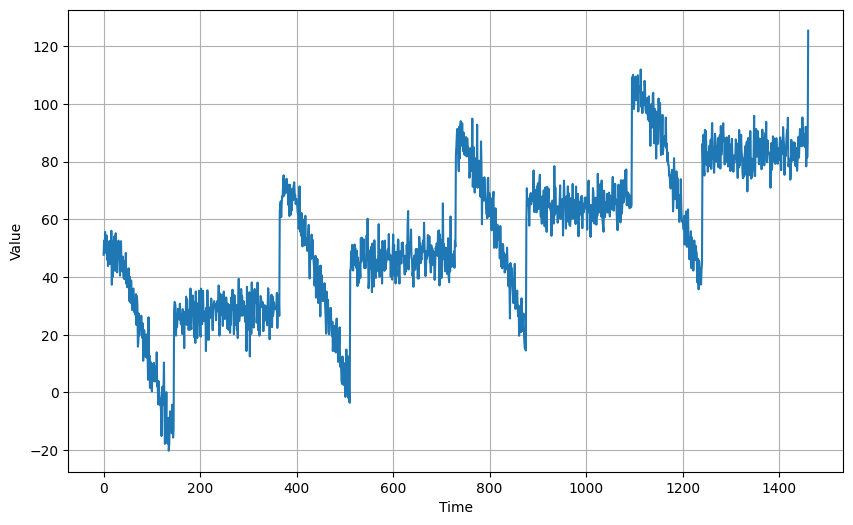

In [4]:
time = np.arange( 4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend( time, slope) + seasonality( time, period=365, amplitude=amplitude)

series += noise( time, noise_level)

plot_series( time, series)

In [5]:
split_time = 1000

time_train = time[ :split_time]
x_train = series[ :split_time]

time_valid = time[ split_time:]
x_valid = series[ split_time:]

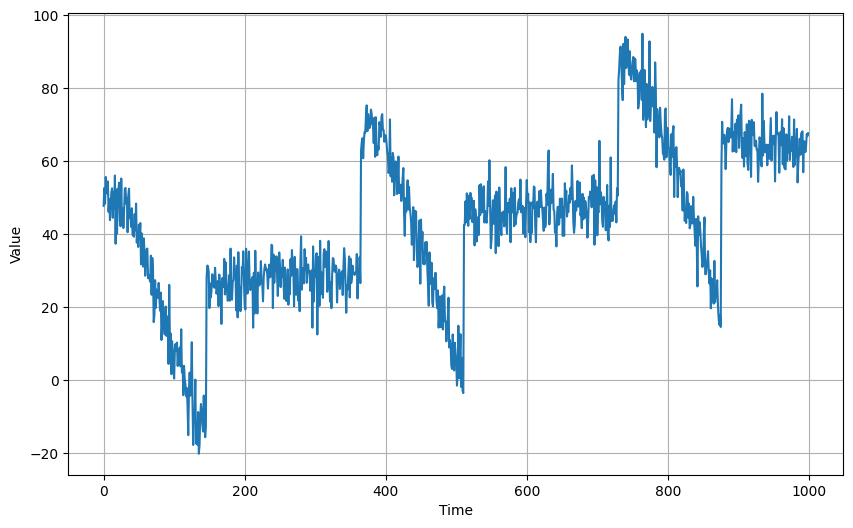

In [6]:
plot_series( time_train, x_train)

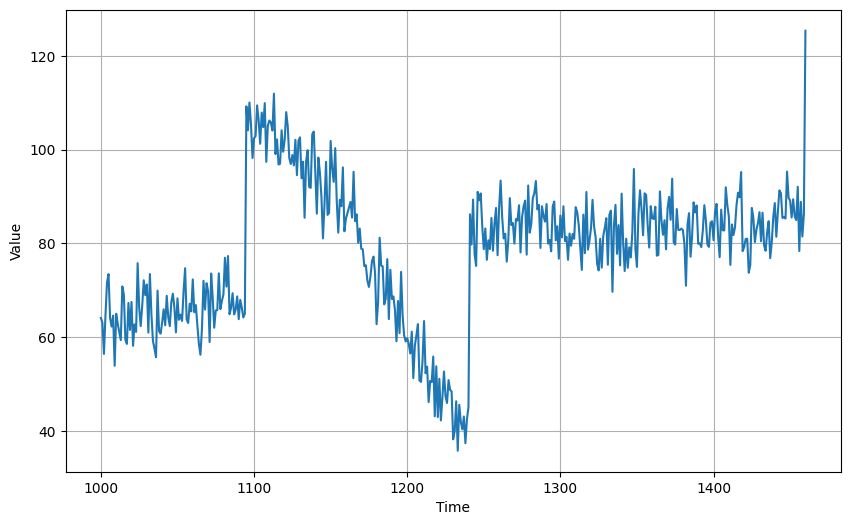

In [7]:
plot_series( time_valid, x_valid)

In [8]:
def windowed_dataset( series, window_size, batch_size, shuffle_buffer):
	dataset = tf.data.Dataset.from_tensor_slices( series)
	
	dataset = dataset.window( window_size + 1, shift=1, drop_remainder=True)

	dataset = dataset.flat_map( lambda window: window.batch( window_size + 1))

	dataset = dataset.map( lambda window: ( window[ :-1], window[ -1]))

	dataset = dataset.shuffle( shuffle_buffer)

	dataset = dataset.batch( batch_size).prefetch( 1)

	return dataset

In [9]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
dataset = windowed_dataset( x_train, window_size, batch_size, shuffle_buffer_size)

In [11]:
for window in dataset.take( 1):
	print( f"data type: { type( window)}")
	print( f"number of elements in the tuple: { len( window)}")
	print( f"shape of first element: { window[ 0].shape}")
	print( f"shape of second element: { window[ 1].shape}")

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [12]:
l0 = tf.keras.layers.Dense( 1, input_shape=[ window_size])

model = tf.keras.models.Sequential( [ l0])

print( f"Layer weights: \n { l0.get_weights()} \n")

model.summary()

Layer weights: 
 [array([[ 0.3106858 ],
       [-0.31438437],
       [-0.09966925],
       [-0.513091  ],
       [-0.4504031 ],
       [-0.3771389 ],
       [ 0.3002631 ],
       [ 0.20015001],
       [ 0.1876415 ],
       [ 0.16720086],
       [-0.25104436],
       [-0.24056637],
       [ 0.25135648],
       [ 0.3223291 ],
       [-0.43469226],
       [ 0.2385087 ],
       [-0.04197252],
       [-0.2976538 ],
       [ 0.26293463],
       [-0.5171338 ]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.compile(
	loss="mse",
	optimizer=tf.keras.optimizers.SGD( learning_rate=1e-6, momentum=0.9)
)

In [14]:
model.fit(
	dataset,
	epochs=100,
	verbose=0
)

In [15]:
print( f"Layer weights: \n { l0.get_weights()} \n")

Layer weights: 
 [array([[ 0.04919473],
       [-0.02191077],
       [ 0.05048517],
       [-0.02229312],
       [-0.08385365],
       [-0.02496979],
       [ 0.06804325],
       [-0.01451406],
       [-0.03328849],
       [ 0.02046668],
       [-0.06114236],
       [-0.05647889],
       [ 0.12550205],
       [ 0.09856079],
       [-0.04720676],
       [ 0.06024197],
       [ 0.08271037],
       [ 0.07921652],
       [ 0.37635303],
       [ 0.3630087 ]], dtype=float32), array([0.01864284], dtype=float32)] 



In [16]:
print( f"shape of series[ 0:20]: { series[ 0:20].shape}")

print( f"shape of series[ 0:20][ np.newaxis]: { series[ 0:20][ np.newaxis].shape}")

print( f"shape of series[ 0:20][ np.newaxis]: { np.expand_dims( series[ 0:20], axis=0).shape}")

print( f"model prediction: { model.predict( series[ 0:20][ np.newaxis], verbose=0)}")

shape of series[ 0:20]: (20,)
shape of series[ 0:20][ np.newaxis]: (1, 20)
shape of series[ 0:20][ np.newaxis]: (1, 20)
model prediction: [[46.455265]]


In [17]:
forecast = []

for time in range( len( series) - window_size):
	forecast.append( model.predict( series[ time:time + window_size][ np.newaxis], verbose=0))

forecast = forecast[ split_time - window_size:]

print( f"length of the forecast list: { len( forecast)}")
print( f"shape of the validation set: { x_valid.shape}")

length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


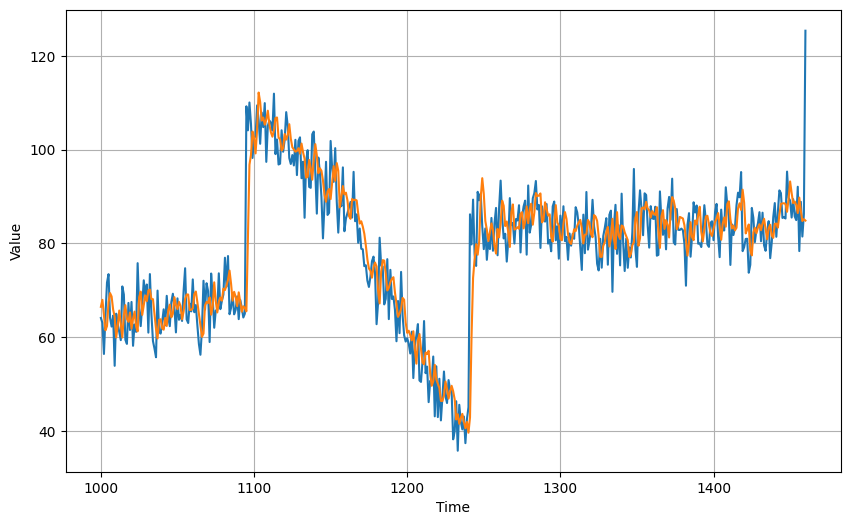

In [18]:
print( f"shape after converting to numpy array: { np.array( forecast).shape}")
print( f"shape after squeezing: { np.array( forecast).squeeze().shape}")

results = np.array( forecast).squeeze()

plot_series( time_valid, ( x_valid, results))

In [19]:
print( tf.keras.metrics.mean_squared_error( x_valid, results).numpy())
print( tf.keras.metrics.mean_absolute_error( x_valid, results).numpy())

45.681866
5.0089517
